In [1]:
import numpy  as np 
import pandas as pd
from sklearn.model_selection import TimeSeriesSplit

from   glob   import glob
import itertools
import importlib
import time
from datetime import datetime
import os

from concurrent.futures import ProcessPoolExecutor

from tp_config import *
from tp_utils.data_provider import read_prices, read_data

np.set_printoptions(edgeitems=30, linewidth=1000, formatter=dict(float=lambda x: "%.3g" % x))
np.set_printoptions(precision=8)

from IPython.display import Markdown, display
def printmd(string):
    display(Markdown("**"+string+"**"))

In [2]:
init_data = {'exchange_commission': 0.0, #percent
#             'start_capital'     : 1,
             'buy_correction'    : 1.0001,
             'sell_correction'   : 0.9999,
             'robot_name'        : '',
             'market'            : '',
             'kline'             : ''  
            }

from TA_robots import *
robot = ma_2_crossover()
params = robot.ps_ranges

prices = read_data('SOL-USDC', '5m')
signals = robot.signals(prices, 16, 30)

ModuleNotFoundError: No module named 'talib'

In [3]:
def fastsim_01(prices, signals, init_data):
    """ Trade simulation with one contract
    """
    commission      = init_data['exchange_commission']/100
#    one_contract    = init_data['start_capital']
    buy_correction  = init_data['buy_correction']
    sell_correction = init_data['sell_correction']

    s1 = signals[signals!=0]

    if len(s1) == 0:
        profit = np.zeros(1)
        returns = np.zeros(1)
        trades = 0
    else:
        inds = np.where(signals!=0)
        s2 = s1 + 1
        s3 = np.roll(s2,1)
        s3[0] = 0
        s4 = np.logical_xor(s2,s3)
        inds1  = inds[0][s4]
        trades = int(len(inds1)/2)
        inds2 = inds1[:trades*2]
        
        start   = len(prices) - len(signals) 
        prices1 = prices[start:]
        prices2 = prices1[inds2]
        prices3 = prices2
        prices3 = prices3.reshape(-1,2)
        prices_sell = prices3[:,1]*sell_correction*(1 - commission)
        prices_buy  = prices3[:,0]*buy_correction*(1 + commission) 
        profit =  prices_sell - prices_buy 
        returns = prices_sell/prices_buy - 1
    return [profit, returns, trades]

In [75]:
test_prices = torch.zeros(100)
test_signals = torch.Tensor(np.tile([1, - 1], 50))
init_data = torch.Tensor([1,1,1])
trades = fastsim_02(test_prices, test_signals, init_data)

%timeit fastsim_02(test_prices, test_signals, init_data)

302 µs ± 6.29 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [78]:
#Тесты
test_prices = np.zeros(100)
test_signals = np.tile([1, - 1], 50)
trades = fastsim_01(test_prices, test_signals, init_data)
%timeit fastsim_01(test_prices, test_signals, init_data)
assert trades[0].sum() == 0

test_prices = np.arange(1,101)
trades = fastsim_01(test_prices, test_signals, init_data)
#assert trades[0].sum() == 50

D:\Anaconda\lib\site-packages\ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in true_divide


75.4 µs ± 991 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [4]:
import collections
from pyswarm import pso
from TA_robots import ma_2_crossover, ma_2_crossover_ichimoku, kestner_ma, macd, rsi, ma_rsi,  rsi_ma
#from empyrical import sharpe_ratio, sortino_ratio, calmar_ratio, omega_ratio
    
def max_drawdown(cum_profit):
    high_val = np.maximum.accumulate(cum_profit)
    drawdown = cum_profit - high_val
    return drawdown
 
def max_len(trades):
    """ Возвращает максимальную длину последовательности минусовых сделок"""
    xx = np.sign(trades[0])
    s = 0
    res = collections.defaultdict(int)
    for i in range(xx.shape[0]):
        if xx[i] == -1:
            s = s + 1
        else:
            res[s] = res[s] + 1
            s = 0
    return max(res.keys())

def opt_fun(params, swarmsize = 50, maxiter = 40, trials = 3):
    lb = [x[0] for x in params]
    ub = [x[1] for x in params]

    prev_fopt = np.inf
    # Run the optimization
    for i in range(trials):
        xopt, fopt = pso(obj_fun, lb, ub, swarmsize=swarmsize, maxiter=maxiter)
        print('OPTIMAL PARAMETERS:')
        
        print([int(x) for x in xopt], '%5.4f' % -fopt)
        if  fopt < prev_fopt:
            best_xopt = xopt
            best_fopt = fopt
            prev_fopt = fopt
    #fastsim_01(prices["C"].values, signals, init_data)
    return (best_xopt, best_fopt)

def obj_fun(p):
    xx = [int(x) for x in p]
    signals = robot.signals(train_X, *xx)
    trades = fastsim_01(train_X['C'].values, signals, init_data)
    if trades[-1] == 0:
        of = np.inf
    else:
        profit = trades[0]
        dd = max_drawdown(profit.cumsum())
        dd = [1] if len(dd) == 0 else dd
        #of = profit.sum()/dd.min() * np.sqrt(trades[1])
        #of = profit.sum()/dd.min()
        #of = -profit.sum()/max_len(trades)        
        of = -profit.sum()
        #of = -dd.min()
        #of = -omega_ratio(trades[1])* np.sqrt(trades[-1])
        #of = -sharpe_ratio(trades[1]) * np.sqrt(trades[-1])
        #of = -calmar_ratio(trades[1]) * trades[-1]
    return of

def get_robots() :
    module  = importlib.import_module('TA_robots')
    rnames = module.robots
    #rnames = ['rsi']
    robots = []
    for robot_name in rnames:
        cl = getattr(module, robot_name)
        robot = cl()
        robots.append(robot)
    return robots

        
def stats(robot, p, prices):
    xx = [int(x) for x in p]
    signals = robot.signals(prices, *xx)
    trades = fastsim_01(prices['C'].values, signals, init_data)
    if trades[-1] == 0:
        of = np.inf
        return [0, -100, 0]
    else:
        profit = trades[0]
        dd = max_drawdown(profit.cumsum())
        dd = [1] if len(dd) == 0 else dd
        #of = profit.sum()/dd.min() * trades[1] ** 1.5
        #of = profit.sum()/dd.min()
        #of = -profit.sum()/max_len(trades)        
    return [profit.sum(), dd.min(), trades[-1]]

from pylab import plt

def test_robot(robot, params, prices):
    signals = robot.signals(prices, *[int(x) for x in params])
    trades  =  fastsim_01(prices["C"].values, signals, init_data)

    print(xopt)
    res = pd.DataFrame()
    res["cum_profit"] = trades[0].cumsum()
    res["cum_ret"] = (trades[1] + 1).cumprod()
    res['drawdown'] = max_drawdown(res["cum_profit"])

    fig, axes = plt.subplots(nrows=3, ncols=1, figsize = (10,8))

    res['cum_profit'].plot(ax=axes[0])
    res['drawdown'].plot(ax=axes[1]) 
    res["cum_ret"].plot(ax = axes[2])
    plt.show()

In [11]:
asset = 'LEND-BTC'
prices = read_data(asset, '15m', '2018-02-06')
train_X = prices
#robot = rsi_ma()#_ichimoku() #rsi()
robot = ma_2_crossover_ichimoku()
robot = ma_2_crossover()


# Bounds for parameters space
params = robot.ps_ranges
#params = ([14, 24], [36,44], [56,64])
xopt, fopt = opt_fun(params, 50, 40)

Stopping search: maximum iterations reached --> 40
OPTIMAL PARAMETERS:
[56, 94] 0.0000
Stopping search: maximum iterations reached --> 40
OPTIMAL PARAMETERS:
[56, 94] 0.0000
Stopping search: maximum iterations reached --> 40
OPTIMAL PARAMETERS:
[56, 94] 0.0000


[56.7016857  94.03499988]


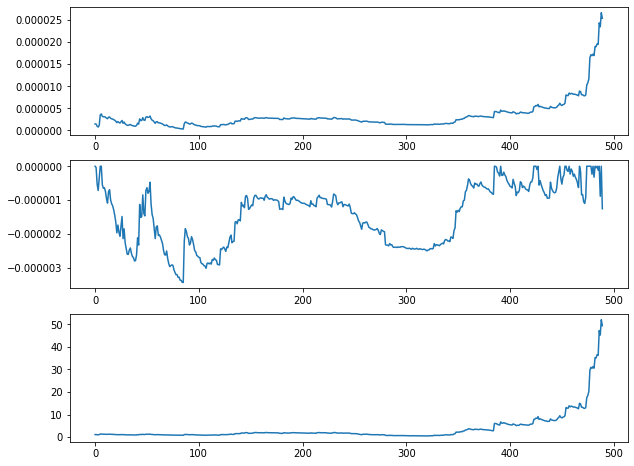

In [12]:
test_robot(robot,xopt,prices)

In [129]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
    
asset = 'BNB-USDT'
prices = read_data(asset, '1h', '2018-02-06')

robot = rsi_ma()
robot = ma_2_crossover()
#robot = kestner_ma()
params = robot.ps_ranges



In [135]:
anchor = False
tscv = TimeSeriesSplit(n_splits = 10)
res = []
i = 0
k = 0 
for train_index, test_index in tscv.split(prices):
    if anchor :
        i = i + 1
        if i <= 5:
            continue
        else:
            k = k + 1
            train_index = train_index[len(test_index)*k:]
            
    print(len(train_index), len(test_index))
    train_X = prices.iloc[train_index]
    test_X = prices.iloc[test_index]
    #xopt, fopt = opt_fun(params, 50, 50, 1)

    #test_robot(robot,xopt,test_X)
    profit, dd, trades = stats(robot, xopt, test_X)
    res.append([profit, dd, trades])
    print("Test: profit %f dd %f trades %d"  %(profit, dd, trades))

1794 1791
Test: profit 6.675399 dd -1.363165 trades 34
3585 1791
Test: profit -0.807974 dd -3.104452 trades 39
5376 1791
Test: profit -0.550054 dd -1.373680 trades 45
7167 1791
Test: profit 3.378913 dd -0.363291 trades 39
8958 1791
Test: profit 10.605993 dd -2.376513 trades 37
10749 1791
Test: profit 2.633308 dd -4.509865 trades 39
12540 1791
Test: profit -0.719908 dd -3.173142 trades 40
14331 1791
Test: profit -0.836222 dd -3.046366 trades 45
16122 1791
Test: profit 7.515454 dd -2.133078 trades 36
17913 1791
Test: profit 3.026564 dd -1.843500 trades 43


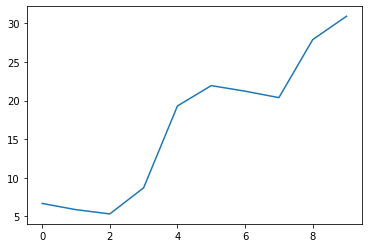

In [136]:
df = pd.DataFrame(res, columns = ['profit', 'dd', 'trades'])
df['profit'].cumsum().plot()
plt.show()

In [138]:
xopt

array([14.35287484, 24.96455316])

Stopping search: maximum iterations reached --> 50
OPTIMAL PARAMETERS:
[61, 160] 5.8516
[ 61.13211915 160.        ]


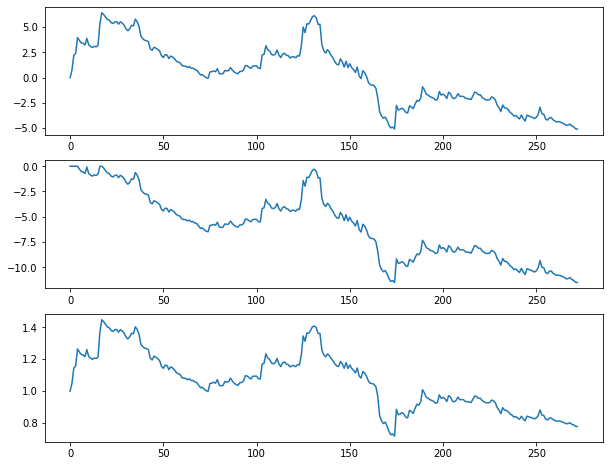

In [14]:
from sklearn.model_selection import train_test_split

robot = ma_2_crossover()
asset = 'BNB-USDT'
prices = read_data(asset, '5m', '2018-02-06')
robot = rsi_ma()
robot = ma_2_crossover()
params = robot.ps_ranges


train_X, test_X = train_test_split(prices, train_size = 0.7, shuffle = False)

xopt, fopt = opt_fun(params, 50, 50, 1)

test_robot(robot,xopt,test_X)

## Mass

In [ ]:
asset = 'BNB-BTC'

tfs = ['5m', '15m', '30m', '1h', '2h', '4h', '6h']

robot = ma_2_crossover()
params = robot.ps_ranges

res = []
for tf in tfs:
    print(tf)
    prices = read_data(asset, tf, '2018-02-06')
    xopt, fopt = opt_fun(params)
    res.append([xopt, fopt])

In [12]:
assets[3:4]

['ETH-USDT']

In [22]:
robots = get_robots()
robots

In [9]:
np.round([1.2, 3.5]).astype(int).tolist()

[1, 4]

In [23]:
#assets = ['BTC-USDT', 'BNB-USDT', 'LINK-USDT', 'ETH-USDT', 'EOS-USDT', 'BCH-USDT', 'LTC-USDT']
assets = ['LEND-USDT']
#assets = ['LINK-USDT', 'LINK-BTC']
tfs = ['5m', '15m', '30m', '1h']
#tfs = ['1m', '3m']
robots = get_robots()

res = []
pair = assets[0].split('-')[1]
for asset in assets:
    for robot in robots:
        for tf in tfs:
            printmd(f"{robot.robot_name} {asset} {tf}")
            prices = read_data(asset, tf, '2018-02-06')           
            prices, test_X = train_test_split(prices, train_size = 0.7, shuffle = False)
            params = robot.ps_ranges
            
            xopt, fopt = opt_fun(params, 50, 50, 3)
            xopt = np.round(xopt).astype(int).tolist()
            profit, dd, trades = stats(robot, xopt, test_X)
            print("Test: profit %f dd %f trades %d"  %(profit, dd, trades))
            res.append([asset, tf, robot.robot_name, xopt, profit, dd, trades])

            df = pd.DataFrame(res, columns = ['asset','tf', 'robot', 'params', 'profit', 'dd', 'trades'])
            df.to_csv('dd_' + pair + '.csv', index = False)

**ma-2-crossover LEND-USDT 5m**

Stopping search: maximum iterations reached --> 50
OPTIMAL PARAMETERS:
[61, 160] 5.8516
Stopping search: maximum iterations reached --> 50
OPTIMAL PARAMETERS:
[61, 160] 5.8516
Stopping search: maximum iterations reached --> 50
OPTIMAL PARAMETERS:
[61, 160] 5.8516
Test: profit 0.097591 dd -0.015003 trades 15


**ma-2-crossover LEND-USDT 15m**

Stopping search: maximum iterations reached --> 50
OPTIMAL PARAMETERS:
[61, 160] 5.8516
Stopping search: maximum iterations reached --> 50
OPTIMAL PARAMETERS:
[61, 160] 5.8516
Stopping search: maximum iterations reached --> 50
OPTIMAL PARAMETERS:
[61, 160] 5.8516
Test: profit 0.055668 dd -0.007678 trades 6


**ma-2-crossover LEND-USDT 30m**

Stopping search: maximum iterations reached --> 50
OPTIMAL PARAMETERS:
[61, 160] 5.8516
Stopping search: maximum iterations reached --> 50
OPTIMAL PARAMETERS:
[61, 160] 5.8516
Stopping search: maximum iterations reached --> 50
OPTIMAL PARAMETERS:
[61, 160] 5.8516
Test: profit 0.062156 dd -0.001464 trades 2


**ma-2-crossover LEND-USDT 1h**

Stopping search: maximum iterations reached --> 50
OPTIMAL PARAMETERS:
[61, 160] 5.8516
Stopping search: maximum iterations reached --> 50
OPTIMAL PARAMETERS:
[61, 160] 5.8516
Stopping search: maximum iterations reached --> 50
OPTIMAL PARAMETERS:
[61, 160] 5.8516
Test: profit 0.000000 dd -100.000000 trades 0


**ma-2-crossover-ichimoku LEND-USDT 5m**

Stopping search: maximum iterations reached --> 50
OPTIMAL PARAMETERS:
[61, 157] 8.8992
Stopping search: maximum iterations reached --> 50
OPTIMAL PARAMETERS:
[62, 155] 9.5006
Stopping search: maximum iterations reached --> 50
OPTIMAL PARAMETERS:
[61, 157] 8.8992
Test: profit 0.079649 dd -0.015354 trades 14


**ma-2-crossover-ichimoku LEND-USDT 15m**

Stopping search: maximum iterations reached --> 50
OPTIMAL PARAMETERS:
[61, 157] 8.8992
Stopping search: maximum iterations reached --> 50
OPTIMAL PARAMETERS:
[61, 157] 8.8992
Stopping search: maximum iterations reached --> 50
OPTIMAL PARAMETERS:
[61, 157] 8.8992
Test: profit 0.065307 dd -0.007359 trades 5


**ma-2-crossover-ichimoku LEND-USDT 30m**

Stopping search: maximum iterations reached --> 50
OPTIMAL PARAMETERS:
[61, 159] 8.6702
Stopping search: maximum iterations reached --> 50
OPTIMAL PARAMETERS:
[61, 157] 8.8992
Stopping search: maximum iterations reached --> 50
OPTIMAL PARAMETERS:
[62, 155] 9.5006
Test: profit 0.060711 dd 0.000000 trades 2


**ma-2-crossover-ichimoku LEND-USDT 1h**

Stopping search: maximum iterations reached --> 50
OPTIMAL PARAMETERS:
[61, 157] 8.8992
Stopping search: maximum iterations reached --> 50
OPTIMAL PARAMETERS:
[61, 159] 8.6702
Stopping search: maximum iterations reached --> 50
OPTIMAL PARAMETERS:
[61, 157] 8.8992
Test: profit 0.000000 dd -100.000000 trades 0


**kestner-ma LEND-USDT 5m**

Stopping search: maximum iterations reached --> 50
OPTIMAL PARAMETERS:
[77, 19, 117, 30] 6.2150
Stopping search: maximum iterations reached --> 50
OPTIMAL PARAMETERS:
[47, 72, 120, 30] 9.4595
Stopping search: maximum iterations reached --> 50
OPTIMAL PARAMETERS:
[48, 78, 117, 30] 8.8853
Test: profit 0.091673 dd -0.020098 trades 15


**kestner-ma LEND-USDT 15m**

Stopping search: maximum iterations reached --> 50
OPTIMAL PARAMETERS:
[47, 72, 120, 30] 9.4595
Stopping search: maximum iterations reached --> 50
OPTIMAL PARAMETERS:
[47, 72, 120, 30] 9.4595
Stopping search: maximum iterations reached --> 50
OPTIMAL PARAMETERS:
[47, 72, 120, 30] 9.4595
Test: profit 0.052989 dd -0.010044 trades 5


**kestner-ma LEND-USDT 30m**

Stopping search: maximum iterations reached --> 50
OPTIMAL PARAMETERS:
[47, 72, 120, 30] 9.4595
Stopping search: maximum iterations reached --> 50
OPTIMAL PARAMETERS:
[64, 45, 118, 30] 6.6317
Stopping search: maximum iterations reached --> 50
OPTIMAL PARAMETERS:
[56, 72, 120, 30] 8.6681
Test: profit 0.048375 dd 0.000000 trades 3


**kestner-ma LEND-USDT 1h**

Stopping search: maximum iterations reached --> 50
OPTIMAL PARAMETERS:
[47, 72, 120, 30] 9.4595
Stopping search: maximum iterations reached --> 50
OPTIMAL PARAMETERS:
[47, 72, 120, 30] 9.4595
Stopping search: maximum iterations reached --> 50
OPTIMAL PARAMETERS:
[56, 72, 120, 30] 8.6681
Test: profit 0.000000 dd -100.000000 trades 0


**ma-rsi LEND-USDT 5m**

Stopping search: maximum iterations reached --> 50
OPTIMAL PARAMETERS:
[47, 22, 79] 10.4817
Stopping search: maximum iterations reached --> 50
OPTIMAL PARAMETERS:
[49, 12, 74] 4.5772
Stopping search: maximum iterations reached --> 50
OPTIMAL PARAMETERS:
[5, 24, 80] 13.7537
Test: profit 0.069399 dd 0.000000 trades 2


**ma-rsi LEND-USDT 15m**

Stopping search: maximum iterations reached --> 50
OPTIMAL PARAMETERS:
[74, 18, 60] 3.7761
Stopping search: maximum iterations reached --> 50
OPTIMAL PARAMETERS:
[72, 13, 78] 2.3198
Stopping search: maximum iterations reached --> 50
OPTIMAL PARAMETERS:
[6, 20, 80] 14.2239
Test: profit 0.066168 dd 0.000000 trades 2


**ma-rsi LEND-USDT 30m**

Stopping search: maximum iterations reached --> 50
OPTIMAL PARAMETERS:
[56, 21, 77] 6.9931
Stopping search: maximum iterations reached --> 50
OPTIMAL PARAMETERS:
[5, 24, 80] 13.7537
Stopping search: maximum iterations reached --> 50
OPTIMAL PARAMETERS:
[74, 11, 68] 3.4871
Test: profit 0.050997 dd 0.000000 trades 1


**ma-rsi LEND-USDT 1h**

Stopping search: maximum iterations reached --> 50
OPTIMAL PARAMETERS:
[72, 19, 71] 2.2703
Stopping search: maximum iterations reached --> 50
OPTIMAL PARAMETERS:
[26, 17, 80] 8.8087
Stopping search: maximum iterations reached --> 50
OPTIMAL PARAMETERS:
[5, 24, 80] 13.7537
Test: profit 0.000000 dd -100.000000 trades 0


**rsi_ma LEND-USDT 5m**

Stopping search: maximum iterations reached --> 50
OPTIMAL PARAMETERS:
[10, 29, 80, 119] 21.2877
Stopping search: maximum iterations reached --> 50
OPTIMAL PARAMETERS:
[11, 32, 78, 114] 23.6570
Stopping search: maximum iterations reached --> 50
OPTIMAL PARAMETERS:
[17, 40, 67, 107] 20.4784
Test: profit 0.051169 dd -0.013739 trades 14


**rsi_ma LEND-USDT 15m**

Stopping search: maximum iterations reached --> 50
OPTIMAL PARAMETERS:
[10, 30, 80, 106] 20.5268
Stopping search: maximum iterations reached --> 50
OPTIMAL PARAMETERS:
[17, 36, 80, 114] 26.0649
Stopping search: maximum iterations reached --> 50
OPTIMAL PARAMETERS:
[11, 32, 78, 114] 23.6570
Test: profit 0.000000 dd -100.000000 trades 0


**rsi_ma LEND-USDT 30m**

Stopping search: maximum iterations reached --> 50
OPTIMAL PARAMETERS:
[17, 40, 67, 119] 24.6516
Stopping search: maximum iterations reached --> 50
OPTIMAL PARAMETERS:
[18, 37, 79, 114] 25.4974
Stopping search: maximum iterations reached --> 50
OPTIMAL PARAMETERS:
[12, 34, 72, 114] 21.2231
Test: profit 0.019448 dd 0.000000 trades 1


**rsi_ma LEND-USDT 1h**

Stopping search: maximum iterations reached --> 50
OPTIMAL PARAMETERS:
[18, 37, 79, 115] 25.0078
Stopping search: maximum iterations reached --> 50
OPTIMAL PARAMETERS:
[17, 40, 67, 119] 24.6516
Stopping search: maximum iterations reached --> 50
OPTIMAL PARAMETERS:
[15, 39, 70, 115] 22.6604
Test: profit 0.035517 dd 0.000000 trades 1


**rsi LEND-USDT 5m**

Stopping search: maximum iterations reached --> 50
OPTIMAL PARAMETERS:
[9, 22, 63] 12.8110
Stopping search: maximum iterations reached --> 50
OPTIMAL PARAMETERS:
[15, 22, 61] 13.1162
Stopping search: maximum iterations reached --> 50
OPTIMAL PARAMETERS:
[9, 22, 67] 15.1577
Test: profit 0.008826 dd -0.026085 trades 24


**rsi LEND-USDT 15m**

Stopping search: maximum iterations reached --> 50
OPTIMAL PARAMETERS:
[16, 23, 60] 12.1906
Stopping search: maximum iterations reached --> 50
OPTIMAL PARAMETERS:
[20, 39, 80] 13.3324
Stopping search: maximum iterations reached --> 50
OPTIMAL PARAMETERS:
[15, 22, 61] 13.1162
Test: profit 0.051956 dd 0.000000 trades 2


**rsi LEND-USDT 30m**

Stopping search: maximum iterations reached --> 50
OPTIMAL PARAMETERS:
[9, 22, 67] 15.1577
Stopping search: maximum iterations reached --> 50
OPTIMAL PARAMETERS:
[9, 22, 61] 13.5711
Stopping search: maximum iterations reached --> 50
OPTIMAL PARAMETERS:
[20, 39, 80] 13.3324
Test: profit 0.030588 dd 0.000000 trades 4


**rsi LEND-USDT 1h**

Stopping search: maximum iterations reached --> 50
OPTIMAL PARAMETERS:
[15, 22, 61] 13.1162
Stopping search: maximum iterations reached --> 50
OPTIMAL PARAMETERS:
[15, 22, 61] 13.1162
Stopping search: maximum iterations reached --> 50
OPTIMAL PARAMETERS:
[15, 22, 61] 13.1162
Test: profit 0.000000 dd -100.000000 trades 0


In [26]:
fastsim = fastsim_01


robots = get_robots()

init_data = {'exchange_commission': 0.075, #percent
             'start_capital'     : 100,
             'buy_correction'    : 1.001,
             'sell_correction'   : 0.999,
             'robot_name'        : '',
             'market'            : '',
             'kline'             : ''  
            }

data_path = DATA_PATH_CRYPTO
pair = 'USDT'
#markets = glob(data_path + '/' + pair +'/*-' + pair)
#markets = [x.split('/')[-1] for x in markets]
fast_trend = ['ADA-BTC', 'EOS-BTC', 'TRX-BTC', 'ONT-BTC', 'NEO-BTC','ZIL-BTC', 'XRP-BTC'] #april 2018
markets = ['BTC-USDT', 'LINK-USDT', 'BNB-USDT']
#markets = ['XLM-BTC']
timeframes = ['3m', '5m',  '15m', '30m', '1h']
timeframes = ['15m', '30m', '1h', '2h', '4h','6h']
timeframes = ['3m', '5m']

def trade_simulation(params):
    signals = robot.signals(prices, *params)

    profit, trades = fastsim_01(ticks, signals, init_data)
    res = [init_data['market'], init_data['kline']] + [profit.sum(), trades] + [init_data['robot_name']] + list(params)
 
    return res #Don't remove

def trade_statistics(prices, trade_data, init_data):
    #trade statistics        
    profit = trade_data.iloc[-1]['cum_profit']       
    s = trade_data['signal']
    trades = s[s==-1].shape[0] 
    bnh = prices[-1] / prices[0] * init_data['start_capital']
    profit_to_bnh = round(profit/bnh, 2)
    
    ts = [init_data['market'], init_data['kline'], profit, trades, profit_to_bnh]
    return ts

def cp_gen(params):
    pr = []
    for p in params:
        pr.append(np.arange(*p))
        
    pl = [x for x in itertools.product(*pr)]        
    return pl

## Single 

In [27]:
train_split = 0.5
elitarism = 10
from_date = ''
to_date = ''

#Стираем старые логи
log_files = glob(PATH_TO_LOGS + "/*")
for fn in log_files:
    os.remove(fn)

all_res = []
start_time_all = time.time() 
for robot in robots:
    robot_name = robot.robot_name
    print(robot_name, ": ", robot.comment)
    params = robot.ps_ranges 
    params_list = cp_gen(params)
    for market in markets:
        print('\t ', market)
        for kline in timeframes:
            print('\t\t', kline)
            data = read_data(market, kline, from_date, to_date)
            train = int(train_split * data.shape[0])
            prices = data[:train]
            ticks = prices['C'].values
            
            init_data['robot_name'] = robot.robot_name
            init_data['market'] = market
            init_data['kline'] = kline
            start = time.time()
     
            all_res = list(map(trade_simulation, params_list))
            #print(market, kline,  "Time taken = {0:.5f}".format(time.time() - start))   
            
            df_train_res = pd.DataFrame(all_res)
            df_train_res = df_train_res.sort_values(2, ascending = False)
            df_train_res = df_train_res.reset_index(drop = True)
            df_train_res = df_train_res[df_train_res[2] > 0]
            
            if df_train_res.shape[0] > elitarism:
                prices = data[train:]
                ticks = prices['C'].values
                res = []
                for ind in range(elitarism):
                    params = tuple(df_train_res.iloc[ind, 5:])  
                    signals = robot.signals(prices, *params)
                    ts = fastsim(ticks, signals, init_data)
                    res.append([init_data['market'], init_data['kline']] + [ts[0].sum(), ts[1]] + [init_data['robot_name']] + list(params))

                df_res = pd.DataFrame(res)
                df_res.to_csv(PATH_TO_LOGS + '/res_' + robot_name + '_' + market +'_' + kline +'.csv', index = False)
print("All done = {0:.2f} min".format((time.time() - start_time_all)/60))

ma :  
	  BTC-USDT
		 3m
		 5m
	  LINK-USDT
		 3m
		 5m
	  BNB-USDT
		 3m
		 5m
ma-2-crossover :  
	  BTC-USDT
		 3m
		 5m
	  LINK-USDT
		 3m
		 5m
	  BNB-USDT
		 3m
		 5m
ma-rsi :  
	  BTC-USDT
		 3m
		 5m
	  LINK-USDT
		 3m
		 5m
	  BNB-USDT
		 3m
		 5m
ma-rsi-01 :  
	  BTC-USDT
		 3m
		 5m
	  LINK-USDT
		 3m
		 5m
	  BNB-USDT
		 3m
		 5m
rsi-ma :  
	  BTC-USDT
		 3m
		 5m
	  LINK-USDT
		 3m
		 5m
	  BNB-USDT
		 3m
		 5m
rsi :  
	  BTC-USDT
		 3m
		 5m
	  LINK-USDT
		 3m
		 5m
	  BNB-USDT
		 3m
		 5m
macd :  
	  BTC-USDT
		 3m
		 5m
	  LINK-USDT
		 3m
		 5m
	  BNB-USDT
		 3m
		 5m
All done = 13.42 min


In [33]:
import os
files = glob(PATH_TO_LOGS +'/res_*L*.csv')

all_res = []
for fn in files:
    dfx = pd.read_csv(fn)
    all_res.append(dfx)
df = pd.concat(all_res) 
df.columns = ['market', 'tf', 'profit', 'trades', 'robot','p1','p2','p3']
df = df.dropna()

In [34]:
df = df[df['profit'] > 0]
#df = df[df['tf'] == '1h']
df = df.sort_values('profit', ascending= False)
df.head(40)

,market,tf,profit,trades,robot,p1,p2,p3
2,LINK-USDT,5m,1.1951647,377,rsi,8,28,78
3,LINK-USDT,5m,1.1594918,386,rsi,14,38,68
6,LINK-USDT,3m,0.7343999,157,ma-rsi-01,8,22,74
6,LINK-USDT,5m,0.7319506,98,ma-rsi-01,52,22,70
9,LINK-USDT,5m,0.5979969,103,ma-rsi-01,52,16,74
5,LINK-USDT,5m,0.5664836,104,ma-rsi-01,52,18,72
2,LINK-USDT,3m,0.4622353,245,ma-rsi-01,36,22,66
5,LINK-USDT,3m,0.3639011,223,ma-rsi-01,36,16,72
7,LINK-USDT,3m,0.3064929,211,ma-rsi-01,36,22,68
3,LINK-USDT,5m,0.3041183,114,ma-rsi,32,18,78


## Parallel

In [ ]:
train_split = 0.5
from_date = ''
to_date = ''

all_res = []
start_time_all = time.time() 
for robot in robots:
    robot_name = robot.robot_name
    print(robot_name, ": ", robot.comment)
    params = robot.ps_ranges 
    params_list = cp_gen(params)
    for market in markets:
        print('\t ', market)
        for kline in timeframes:
            print('\t\t', kline)
            data = read_data(market, kline, from_date, to_date)
            train = int(train_split * data.shape[0])
            prices = data[:train]
            ticks = prices['C'].values
            
            init_data['robot_name'] = robot.robot_name
            init_data['market'] = market
            init_data['kline'] = kline
            start = time.time()
            pool = ProcessPoolExecutor(max_workers = 4)
            with pool as p:            
                all_res = list(p.map(trade_simulation, params_list))
            #print(market, kline,  "Time taken = {0:.5f}".format(time.time() - start))   
            
            df_train_res = pd.DataFrame(all_res)
            df_train_res = df_train_res.sort_values(2, ascending = False)
            prices = data[train:]
            ticks = prices['C'].values
            res = []
            for ind in range(10):
                params = tuple(df_train_res.iloc[ind, 5:])  
                signals = robot.signals(prices, *params)
                ts = fastsim(ticks, signals, init_data)
                res.append([init_data['market'], init_data['kline']] + ts + [init_data['robot_name']] + list(params))
                
            df_res = pd.DataFrame(res)
            df_res.to_csv(PATH_TO_LOGS + '/res_' + robot_name + '_' + market +'_' + kline +'.csv', index = False)
print("All done = {0:.2f} min".format((time.time() - start_time_all)/60))

In [75]:
rsi_win = 14
rsi_sell = 78
rsi = talib.RSI(prices * 100, rsi_win)
rsi[:rsi_win] = 0
sum(rsi>rsi_sell)

145

In [62]:
def simulation(ticks, signals, init_data):
    market          = init_data['market']
    commission      = init_data['exchange_commission']
    start_capital   = init_data['start_capital']
    buy_correction  = init_data['buy_correction']
    sell_correction = init_data['sell_correction']
     
    cur_capital  = start_capital 
    num_shares   = 0
    trade_profit = 0
    cum_profit   = 0
    
    market_position = 0
    start = len(ticks) - len(signals) 
    ticks = ticks[start:]
    trade_statistics = []
    #trade_statistics = np.zeros((len(signals),7))
    for i in range(len(signals)) :
        
        if market_position == 0 and signals[i] == 1:
            price = ticks[i] * buy_correction
            num_shares   = cur_capital * (1-commission)/price
            trade_profit = -cur_capital
            cur_capital  = 0
            market_position = 1
            
        elif market_position == 1 and signals[i] == -1:
            price = ticks[i] * sell_correction
            cur_capital  = (num_shares * price)*(1-commission)
            trade_profit = trade_profit + cur_capital
            cum_profit  += trade_profit
            num_shares   = 0
            market_position = 0
        else:
            signals[i] = 0
            
        trade_statistics.append([ticks[i], signals[i], market_position, cur_capital, num_shares, trade_profit, cum_profit])            
        #trade_statistics[i] = [ticks[i], signals[i], market_position, cur_capital, num_shares, trade_profit, cum_profit]

    df = pd.DataFrame(trade_statistics)
    df.columns = ['price', 'signal', 'MP', 'capital', 'num_shares', 'profit', 'cum_profit']
    df = df.astype({'signal':np.int32, 'MP':np.int32})
    return df
    #return 0

In [ ]:
def simulation_short(ticks, signals, init_data):
    market          = init_data['market']
    commission      = init_data['exchange_commission']
    start_capital   = init_data['start_capital']
    buy_correction  = init_data['buy_correction']
    sell_correction = init_data['sell_correction']
     
    cur_capital  = start_capital 
    num_shares   = 0
    trade_profit = 0
    cum_profit   = 0
    
    market_position = 0
    start = len(ticks) - len(signals) 
    ticks = ticks[start:]
    trade_statistics = []
    #trade_statistics = np.zeros((len(signals),7))
    for i in range(len(signals)) :
        
        #long entry
        if market_position == 0 and signals[i] == 1:
            price = ticks[i] * buy_correction
            num_shares   = cur_capital * (1-commission)/price
            trade_profit = -cur_capital
            cur_capital  = 0
            market_position = 1
        #long exit
        elif market_position == 1 and signals[i] == -1:
            price = ticks[i] * sell_correction
            cur_capital  = (num_shares * price)*(1-commission)
            trade_profit = trade_profit + cur_capital
            cum_profit  += trade_profit
            num_shares   = 0
            market_position = 0
        #short entry
        elif market_position == 0 and signals[i] == -1:
            price = ticks[i] * sell_correction
            num_shares   = cur_capital * (1-commission)/price
            trade_profit = num_shares * price
            market_position = 2
        #short exit
        elif market_position == 2 and signals[i] == 1:    
            price = ticks[i] * buy_correction
            cur_capital  = (num_shares * price)*(1-commission)
            num_shares = 0
            trade_profit = trade_profit - cur_capital
            market_position = 0
        else:
            signals[i] = 0
            
        trade_statistics.append([ticks[i], signals[i], market_position, cur_capital, num_shares, trade_profit, cum_profit])            
        #trade_statistics[i] = [ticks[i], signals[i], market_position, cur_capital, num_shares, trade_profit, cum_profit]

    df = pd.DataFrame(trade_statistics)
    df.columns = ['price', 'signal', 'MP', 'capital', 'num_shares', 'profit', 'cum_profit']
    df = df.astype({'signal':np.int32, 'MP':np.int32})
    return df
    #return 0